In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    average_precision_score, ConfusionMatrixDisplay, RocCurveDisplay
)
import matplotlib.pyplot as plt
target_names = ['Not taking Contract', 'Takes Contract']



In [2]:
data = pd.read_csv('data/wallacecommunications.csv', delimiter=',')
# drop the month value with 'j' as it can be January, June, July
data = data[data['last_contact_this_campaign_month'] != 'j']
# drop ID as it is just identifier and Country
data = data.drop(columns= ['ID', 'country','last_contact_this_campaign_day','conn_tr','town', 
                           'married'])
# Replace the incorrect values to correct value
data['has_tv_package'] = data['has_tv_package'].replace({'n':'no'})
data['last_contact'] = data['last_contact'].replace({'cell':'cellular'})


In [3]:
binary_cols = ['arrears', 'housing', 'has_tv_package']
for cols in binary_cols:
    data[cols] = data[cols].map({'yes':1, 'no':0})

In [4]:
data['never_contacted'] = (data['days_since_last_contact_previous_campaign'] == -1).astype(int)
data['days_since_last_contact_previous_campaign'] = (
    data['days_since_last_contact_previous_campaign'].replace(-1, np.nan)
)

In [5]:
categorical_features = ['job','education', 'last_contact', 'never_contacted',
                         'last_contact_this_campaign_month', 'outcome_previous_campaign']
numerical_features = ['age', 'current_balance', 'this_campaign', 'days_since_last_contact_previous_campaign', 
                      'contacted_during_previous_campaign']

In [6]:
numeric_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='constant', fill_value=999999)),
    ("scaler", StandardScaler())
])

In [7]:
data_processor = ColumnTransformer(
    transformers=[
        ('num', numeric_preprocess, numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ],
    remainder='passthrough'
)

In [8]:
X = data.drop(columns=['new_contract_this_campaign'])
y = data['new_contract_this_campaign'].map({"yes": 1, "no": 0})

In [9]:
X_85, X_test, y_85, y_test = train_test_split(
    X, y, test_size=0.15, random_state=36, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_85, y_85, test_size=0.1765, random_state=36, stratify=y_85
)

In [10]:
lr_pl= Pipeline([
        ('preprocessor', data_processor),
        ('classifier', LogisticRegression(penalty='l1', 
                                          solver='liblinear', 
                                          max_iter=1000, 
                                          random_state=36,
                                          class_weight='balanced'))
    ])

In [11]:
lr_pl.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [12]:
y_pred = lr_pl.predict(X_val)
y_proba = lr_pl.predict_proba(X_val)[:,1]

Logistic Regression  —  Acc: 0.752 | AUC: 0.776


<Figure size 640x480 with 0 Axes>

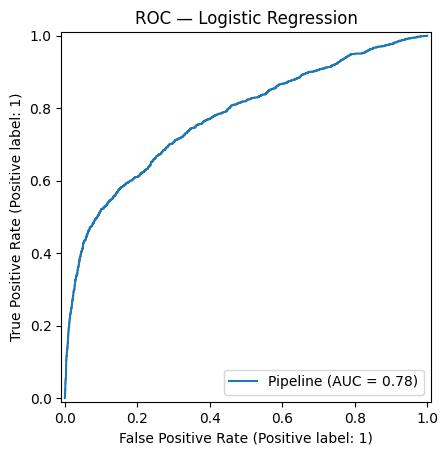

<Figure size 640x480 with 0 Axes>

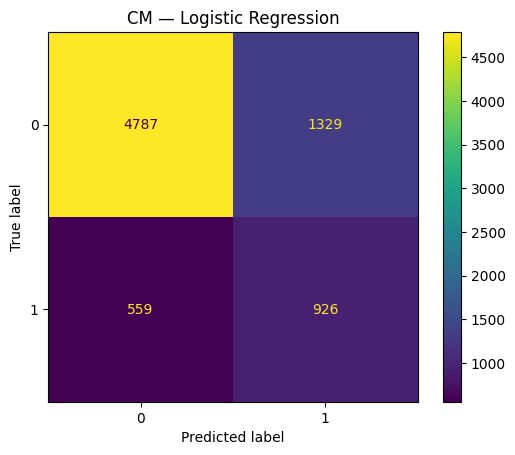


===== BASELINE MODEL ON VALIDATION FOR LOGISTIC REGRESSION =====
Accuracy: 0.7516116300486778
Precision (YES): 0.4106430155210643
Recall (YES): 0.6235690235690236
F1-score: 0.49518716577540106
ROC AUC: 0.7755008665244113
PR AUC: 0.5544894038535133

Confusion Matrix:
 [[4787 1329]
 [ 559  926]]

Classification Report:
                      precision    recall  f1-score   support

Not taking Contract       0.90      0.78      0.84      6116
     Takes Contract       0.41      0.62      0.50      1485

           accuracy                           0.75      7601
          macro avg       0.65      0.70      0.67      7601
       weighted avg       0.80      0.75      0.77      7601



In [13]:
print(f"Logistic Regression  —  Acc: {accuracy_score(y_val, y_pred):.3f} | AUC: {roc_auc_score(y_val, y_proba):.3f}")
fig = plt.figure(); RocCurveDisplay.from_estimator(lr_pl, X_val, y_val); plt.title("ROC — Logistic Regression"); plt.show()
fig = plt.figure(); ConfusionMatrixDisplay.from_predictions(y_val, y_pred); plt.title("CM — Logistic Regression"); plt.show()

print("\n===== BASELINE MODEL ON VALIDATION FOR LOGISTIC REGRESSION =====")
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Precision (YES):", precision_score(y_val, y_pred, pos_label=1))
print("Recall (YES):", recall_score(y_val, y_pred, pos_label=1))
print("F1-score:", f1_score(y_val, y_pred, pos_label=1))
print("ROC AUC:", roc_auc_score(y_val, y_proba))
print("PR AUC:", average_precision_score(y_val, y_proba))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred, target_names=target_names))

In [14]:
param_grid = [
    {'classifier__penalty': ['l1', 'l2'], 
    'classifier__C': [0.01, 0.1, 1.0, 10.0, 100.0], 
    'classifier__solver': ['liblinear'],
    'classifier__class_weight':['balanced', {0:1,1:4},{0:1,1:2.65}]},
]
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=36)

In [15]:
grid_search = GridSearchCV(
    lr_pl, 
    param_grid, 
    cv=cv, 
    scoring='f1',
    verbose=1, 
    n_jobs=-1
)


In [16]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


,estimator,Pipeline(step...liblinear'))])
,param_grid,"[{'classifier__C': [0.01, 0.1, ...], 'classifier__class_weight': ['balanced', {0: 1, 1: 4}, ...], 'classifier__penalty': ['l1', 'l2'], 'classifier__solver': ['liblinear']}]"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [17]:
print(f"Best Penalty: {grid_search.best_params_['classifier__penalty']}")
print(f"Best C value: {grid_search.best_params_['classifier__C']}")
print(f"Best cross-validation score (accuracy): {grid_search.best_score_:.4f}")

Best Penalty: l2
Best C value: 1.0
Best cross-validation score (accuracy): 0.5119


In [18]:
best_model = grid_search.best_estimator_
best_model.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('num',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(fill_value=999999,
                                                                   strategy='constant')),
                                                    ('scaler', StandardScaler())]),
                                    ['age', 'current_balance', 'this_campaign',
                                     'days_since_last_contact_previous_campaign',
                                     'contacted_during_previous_campaign']),
                                   ('cat', OneHotEncoder(drop='first'),
                                    ['job', 'education', 'last_contact',
                                     'never_contacted',
                                     'last_contact_this_campaign_month',
                             

In [19]:
y_pred_ht = best_model.predict(X_val)
y_proba_ht = best_model.predict_proba(X_val)[:,1]

Logistic Regression  —  Acc: 0.835 | AUC: 0.775


<Figure size 640x480 with 0 Axes>

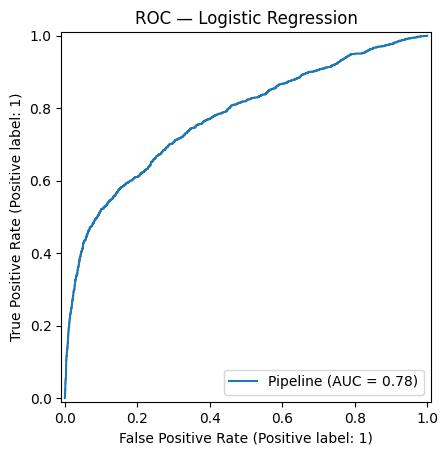

<Figure size 640x480 with 0 Axes>

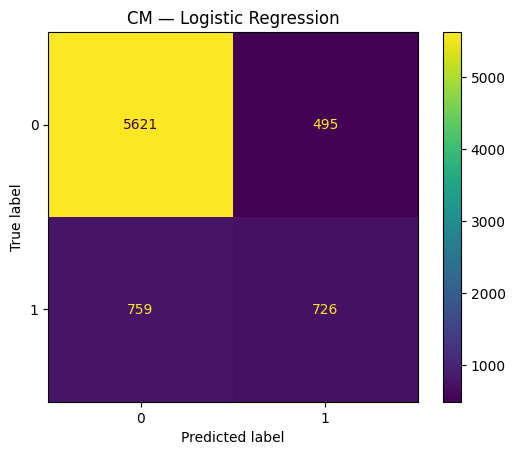


===== HYPERPARAMETERISED MODEL ON VALIDATION =====
Accuracy: 0.8350217076700435
Precision (YES): 0.5945945945945946
Recall (YES): 0.4888888888888889
F1-score: 0.5365853658536586
ROC AUC: 0.7754503834948571
PR AUC: 0.5552194630946509

Confusion Matrix:
 [[5621  495]
 [ 759  726]]

Classification Report:
                      precision    recall  f1-score   support

Not taking Contract       0.88      0.92      0.90      6116
     Takes Contract       0.59      0.49      0.54      1485

           accuracy                           0.84      7601
          macro avg       0.74      0.70      0.72      7601
       weighted avg       0.83      0.84      0.83      7601



In [20]:
print(f"Logistic Regression  —  Acc: {accuracy_score(y_val, y_pred_ht):.3f} | AUC: {roc_auc_score(y_val, y_proba_ht):.3f}")
fig = plt.figure(); RocCurveDisplay.from_estimator(lr_pl, X_val, y_val); plt.title("ROC — Logistic Regression"); plt.show()
fig = plt.figure(); ConfusionMatrixDisplay.from_predictions(y_val, y_pred_ht); plt.title("CM — Logistic Regression"); plt.show()

print("\n===== HYPERPARAMETERISED MODEL ON VALIDATION =====")
print("Accuracy:", accuracy_score(y_val, y_pred_ht))
print("Precision (YES):", precision_score(y_val, y_pred_ht, pos_label=1))
print("Recall (YES):", recall_score(y_val, y_pred_ht, pos_label=1))
print("F1-score:", f1_score(y_val, y_pred_ht, pos_label=1))
print("ROC AUC:", roc_auc_score(y_val, y_proba_ht))
print("PR AUC:", average_precision_score(y_val, y_proba_ht))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_pred_ht))
print("\nClassification Report:\n", classification_report(y_val, y_pred_ht,target_names=target_names))